In [1]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.0 MB/s eta 0:00:00


In [2]:
import keras
print(keras.__version__)

2.15.0


In [3]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# Text CNN
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing import text, sequence
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [5]:
train = pd.read_csv('/content/drive/MyDrive/Coding/AERA/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Coding/AERA/Dataset/test.csv')
val = pd.read_csv('/content/drive/MyDrive/Coding/AERA/Dataset/val.csv')

In [6]:
X_train = train['normalize']
y_train = train['label'].values

X_val = val['normalize']
y_val = val['label'].values

X_test = test['normalize']
y_test = test['label'].values

In [7]:
# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

In [14]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_val, y_val, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

#EMBEDDING_FILE = '/content/drive/MyDrive/MachineLearning/word2vec_vi_syllables_300dims.txt'
EMBEDDING_FILE = '/content/drive/MyDrive/Coding/AERA/word2vec_vi_syllables_100dims.txt'
MODEL_FILE = '/content/drive/MyDrive/Coding/AERA/TextCNN/Text_CNN_Word.h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    #X = sequence.pad_sequences(X, maxlen=sequence_length)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 100
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

In [15]:
# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)

In [16]:
word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [17]:
# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [18]:
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 100)             4355800   ['input_2[0][0]']             
                                                                                                  
 reshape_1 (Reshape)         (None, 100, 100, 1)          0         ['embedding_1[0][0]']         
                                                                                                  
 conv2d_3 (Conv2D)           (None, 99, 1, 32)            6432      ['reshape_1[0][0]']           
                                                                                            

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


133/133 [==============================] - 3s 14ms/step - loss: 0.7235 - accuracy: 0.8371 - val_loss: 0.4621 - val_accuracy: 0.9146
Epoch 2/40
133/133 [==============================] - 2s 12ms/step - loss: 0.3856 - accuracy: 0.9242 - val_loss: 0.3610 - val_accuracy: 0.9146
Epoch 3/40
133/133 [==============================] - 2s 12ms/step - loss: 0.3299 - accuracy: 0.9242 - val_loss: 0.3363 - val_accuracy: 0.9146
Epoch 4/40
133/133 [==============================] - 2s 13ms/step - loss: 0.3061 - accuracy: 0.9242 - val_loss: 0.3136 - val_accuracy: 0.9146
Epoch 5/40
133/133 [==============================] - 2s 12ms/step - loss: 0.2831 - accuracy: 0.9242 - val_loss: 0.2902 - val_accuracy: 0.9146
Epoch 6/40
133/133 [==============================] - 2s 14ms/step - loss: 0.2602 - accuracy: 0.9245 - val_loss: 0.2637 - val_accuracy: 0.9146
Epoch 7/40
133/133 [==============================] - 2s 17ms/step - loss: 0.2323 - accuracy: 0.9274 - val_loss: 0.2346 - val_accuracy: 0.9202
Epoch 8/40

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[[ 312   34   64]
 [  34   63  173]
 [  27   53 8939]]
F1 - micro: 0.9603051861016599
F1 - macro: 0.6931708323725836
Accuracy: 0.9603051861016599


<Axes: >

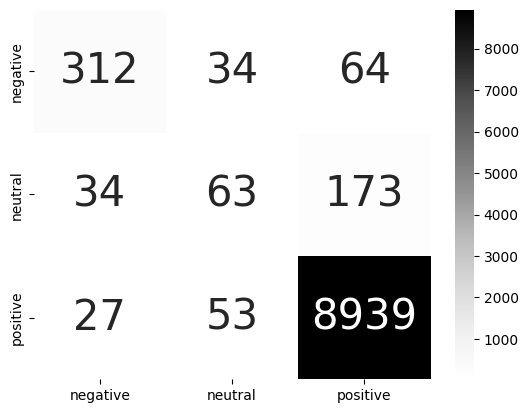

In [19]:
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["negative","neutral","positive"],
                  columns = ["negative","neutral","positive"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
wword

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


133/133 [==============================] - 14s 28ms/step - loss: 0.7942 - accuracy: 0.7041 - val_loss: 0.4244 - val_accuracy: 0.9146
Epoch 2/40
133/133 [==============================] - 2s 12ms/step - loss: 0.3507 - accuracy: 0.9241 - val_loss: 0.3263 - val_accuracy: 0.9146
Epoch 3/40
133/133 [==============================] - 2s 13ms/step - loss: 0.2980 - accuracy: 0.9242 - val_loss: 0.3071 - val_accuracy: 0.9146
Epoch 4/40
133/133 [==============================] - 2s 14ms/step - loss: 0.2780 - accuracy: 0.9242 - val_loss: 0.2884 - val_accuracy: 0.9146
Epoch 5/40
133/133 [==============================] - 2s 13ms/step - loss: 0.2572 - accuracy: 0.9242 - val_loss: 0.2670 - val_accuracy: 0.9146
Epoch 6/40
133/133 [==============================] - 2s 12ms/step - loss: 0.2370 - accuracy: 0.9246 - val_loss: 0.2440 - val_accuracy: 0.9148
Epoch 7/40
133/133 [==============================] - 2s 12ms/step - loss: 0.2149 - accuracy: 0.9272 - val_loss: 0.2208 - val_accuracy: 0.9185
Epoch 8/4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[[ 308   38   64]
 [  34   69  167]
 [  26   45 8948]]
F1 - micro: 0.9614393236416126
F1 - macro: 0.7007309222282351
Accuracy: 0.9614393236416126


<Axes: >

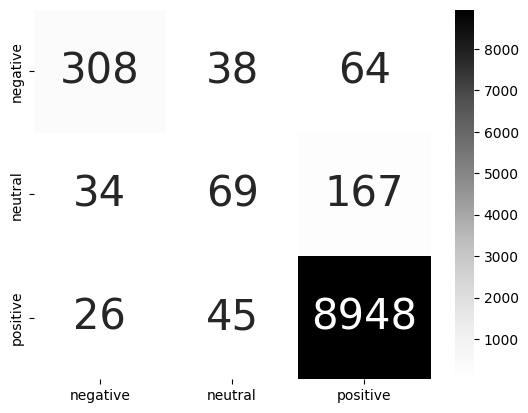

In [13]:
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["negative","neutral","positive"],
                  columns = ["negative","neutral","positive"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})